# Plot copy number variation (CNV) trends

This notebook will generate two figures: the first provides a population-level overview of the prevalence of copy number variations (CNV), while the second visualizes how CNV prevalence changes over time.

**This notebook should take approximately two minutes to run.**

## Setup

Install and import the malariagen Python package:

In [1]:
!pip install malariagen_data -q --no-warn-conflicts
import malariagen_data

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 8.6 MB/s eta 0:00:00

Import required python libraries installed at colab by default.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import fisher_exact
from tqdm import tqdm
from google.colab import drive

## Access Pf8 Data

In [3]:
release_data = malariagen_data.Pf8()
df_samples = release_data.sample_metadata()

We will use the QC pass samples from Pf8.

In [4]:
df_samples_qc_pass = df_samples.loc[df_samples["QC pass"] == True]

## CNV calls

CNV calls were made for six “call regions” of interest for each 24,409 QC-passed sample. Four of the CNV calls were performed for identifying gene amplifications (*mdr1*, *dhps*, *dhfr*, and plasmepsin2/3), and two were for identifying gene deletion (*hrp2* and *hrp3*). For more details on CNV calling, please check Pf8 publication supplementary.

We can access the CNV calls through the Sanger's cloud storage.

In [5]:
cnv_df = pd.read_csv("https://pf8-release.cog.sanger.ac.uk/Pf8_cnv_calls.tsv", sep = "\t")

cnv_df.head()

,Sample,CRT_uncurated_coverage_only,CRT_curated_coverage_only,CRT_breakpoint,CRT_faceaway_only,CRT_final_amplification_call,GCH1_uncurated_coverage_only,GCH1_curated_coverage_only,GCH1_breakpoint,GCH1_faceaway_only,...,PM2_PM3_faceaway_only,PM2_PM3_final_amplification_call,HRP2_uncurated_coverage_only,HRP2_breakpoint,HRP2_deletion_type,HRP2_final_deletion_call,HRP3_uncurated_coverage_only,HRP3_breakpoint,HRP3_deletion_type,HRP3_final_deletion_call
0,FP0008-C,0,0,-,-1,0,-1,-1,-,0,...,0,0,0,-,-,0,0,-,-,0
1,FP0009-C,0,0,-,0,0,0,0,-,0,...,0,0,0,-,-,0,0,-,-,0
2,FP0010-CW,-1,-1,-,0,0,-1,-1,-,0,...,0,0,-1,-,-,-1,-1,-,-,-1
3,FP0011-CW,-1,-1,-,-1,-1,-1,-1,-,0,...,0,0,-1,-,-,-1,-1,-,-,-1
4,FP0012-CW,-1,-1,-,0,0,0,0,-,0,...,0,0,-1,-,-,-1,0,-,-,0


To access the data in one place, we will merge the datasets (`df_samples` and `cnv_df`).

In [6]:
merge_df = cnv_df.merge(df_samples_qc_pass, on = "Sample")

merge_df.head(3)

,Sample,CRT_uncurated_coverage_only,CRT_curated_coverage_only,CRT_breakpoint,CRT_faceaway_only,CRT_final_amplification_call,GCH1_uncurated_coverage_only,GCH1_curated_coverage_only,GCH1_breakpoint,GCH1_faceaway_only,...,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf7
0,FP0008-C,0,0,-,-1,0,-1,-1,-,0,...,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.48,True,Analysis_set,gDNA,True
1,FP0009-C,0,0,-,0,0,0,0,-,0,...,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.95,True,Analysis_set,gDNA,True
2,FP0010-CW,-1,-1,-,0,0,-1,-1,-,0,...,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,87.01,True,Analysis_set,sWGA,True


For gene amplification calls, the genotype values could take one of three values: missing/uncallable (-1), not amplified (0), or amplified (1).

Now, let's check the number of calls for each gene.

In [7]:
for cnv_call in ["HRP2_final_deletion_call", "CRT_final_amplification_call",
                 "HRP3_final_deletion_call", "MDR1_final_amplification_call",
                 "PM2_PM3_final_amplification_call", "GCH1_final_amplification_call"]:
    print(merge_df[cnv_call].value_counts())

HRP2_final_deletion_call
 0    13512
-1    10882
 1       15
Name: count, dtype: int64
CRT_final_amplification_call
 0    22321
-1     2002
 1       86
Name: count, dtype: int64
HRP3_final_deletion_call
 0    13120
-1    11074
 1      215
Name: count, dtype: int64
MDR1_final_amplification_call
 0    19512
-1     4195
 1      702
Name: count, dtype: int64
PM2_PM3_final_amplification_call
 0    17610
-1     4719
 1     2080
Name: count, dtype: int64
GCH1_final_amplification_call
 0    17631
-1     4134
 1     2644
Name: count, dtype: int64


## Figure preperation

We start by defining descriptive labels for the columns that contain values for the call regions. These labels will be displayed in the figure to make the regions identifiable.

In [8]:
cnv_call_ids = {
    "GCH1_final_amplification_call": "$\it{gch1}$ amplification",
    "CRT_final_amplification_call": "$\it{crt}$ amplification",
    "MDR1_final_amplification_call": "$\it{mdr1}$ amplification",
    "PM2_PM3_final_amplification_call": "$\it{plasmepsin2/3}$ amplification",
    "HRP2_final_deletion_call": "$\it{hrp2}$ deletion",
    "HRP3_final_deletion_call": "$\it{hrp3}$ deletion",
}

We define a dictionary which maps the codes for ten major sub-populations to a colour code.

In [9]:
population_colour_map = {
    'SA' : "#4daf4a",
    'AF-W' : "#e31a1c",
    'AF-C' : "#fd8d3c" ,
    'AF-NE' : "#bb8129" ,
    'AF-E' : "#fecc5c",
    'AS-S-E' : "#dfc0eb" ,
    'AS-S-FE' : "#984ea3" ,
    'AS-SE-W' : "#9ecae1",
    'AS-SE-E' : "#3182bd",
    'OC-NG' : "#f781bf"
}


We are ready to generate our first figure, which will consist of six subplots, each corresponding to a different call region. The y-axis of each subplot will display the prevalence of copy number variations (CNVs), while the x-axis will represent the various subpopulations. This should allow for an easy comparison of CNV prevalence across populations for each call region.

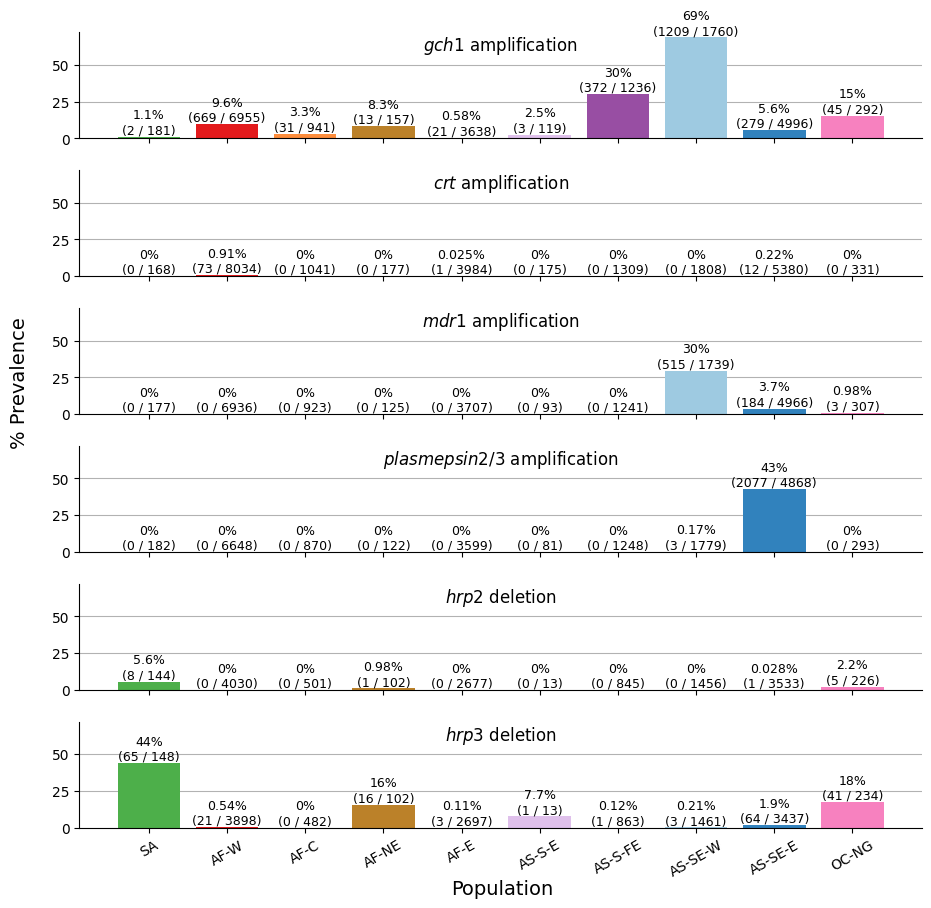

In [10]:
# Figure layout, 6 rows, 1 column, 9x9 inches
fig, axes = plt.subplots(6, 1, figsize=(9, 9), sharex=True, sharey=True)
axes = axes.ravel()

# Iterate over each call region (gene)
for i, (gene, title) in enumerate(cnv_call_ids.items()):

    # Group the data by population and calculate the prevalence and counts of CNV calls
    by_population = merge_df.groupby("Population")[gene].apply(
        lambda x: pd.DataFrame({
            "ratio": [sum(x == 1) / sum(x != -1)],  # Calculate ratio of CNV calls
            "cnv_gt_1": [sum(x == 1)],  # Count samples with CNV call (1)
            "cnv_gt_0_1": [sum(x != -1)]  # Count total samples with valid CNV calls (not -1)
        })
    ).reset_index(level=1, drop=True)

    # Set the population index as a categorical type for sorting purposes
    by_population.index = pd.Categorical(by_population.index, categories=list(population_colour_map.keys()), ordered=True)
    by_population = by_population.sort_index()

    # Create a bar plot for each gene
    bars = axes[i].bar(
        by_population.index, by_population["ratio"] * 100,  # Convert ratio to percentage
        color=[population_colour_map[pop] for pop in by_population.index]  # Color bars based on population
    )

    # Annotate each bar with the percentage and count of CNVs
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,  # Position the annotation at the center of the bar
            height,
            f"{height:.2g}%\n({int(by_population['cnv_gt_1'].iloc[j])} / {int(by_population['cnv_gt_0_1'].iloc[j])})",
            ha="center", va="bottom", fontsize=9  # Set text alignment and font size
        )

    # Set x-axis ticks to the population names and rotate the labels for better visibility
    axes[i].set_xticks(range(len(by_population.index)))  # Position the ticks at each population
    axes[i].set_xticklabels(by_population.index, rotation=30)  # Set population names as labels, rotated by 30 degrees
    axes[i].set_title(title, y=0.75)  # Set the subplot title
    axes[i].spines["top"].set_visible(False)  # Hide the top border of the subplot
    axes[i].spines["right"].set_visible(False)  # Hide the right border of the subplot

    # Add horizontal reference lines at 25% and 50% prevalence for visual guidance
    for y in [25, 50]:
        axes[i].axhline(y=y, linewidth=0.8, color="black", alpha=0.3, zorder=-1)

# Add global labels for the y and x axes
fig.text(s="% Prevalence", x=-0.03, y=0.5, rotation=90, fontsize=14)  # y-axis label
fig.text(s="Population", x=0.46, y=0, fontsize=14)  # x-axis label
plt.tight_layout()

# Vertical space between subplots
fig.subplots_adjust(hspace=0.3)
plt.show()


**Figure Legend.** Population-level overview of the prevalence of copy number variations. Each row shows a series of bars indicating the percentage prevalence of one of the six copy number variations called in Pf8 — CRT (*crt* amplification), HRP2 (*hrp* deletion), PM2_PM3 (plasmepsin 2/3 amplification), MDR1 (*mdr1* amplification), HRP3 (*hrp3* deletion), GCH1 (*gch1* amplification) — in each of the ten colour-coded populations. Each bar comprises the percentage prevalence, as well as the number of samples with the CNV (as the numerator) and the total number of samples with a non-missing CNV call (as the denominator).

### Save the Figure

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fig.savefig("/content/drive/My Drive/pf8-cnv-population-breakdown.png", dpi = 1200, bbox_inches="tight")

## Time-series plots of CNV prevalence

Now it is time to create a time-series plot. Each point will represent the prevalence for a given year in samples from the respective population.  

In addition to plotting prevalence, we will also compute the standard error of a proportion for each point using the formula:  

$$SE = \sqrt{\frac{p(1 - p)}{n}}$$  

where:  
- `p` is the observed proportion (prevalence).  
- `n` is the sample size for that year and population.  

This will help visualize the uncertainty in prevalence estimates over time.






In [ ]:
def calculate_standard_error(s: pd.Series):
    # proportion
    p = s.ratio
    # sample size
    n = s.cnv_gt_0_1

    if n <= 1:
        return np.nan

    return np.sqrt(p * (1 - p) / n)

This plot consists of three subplots, one for each call region (**GCH1**, **MDR1**, and **PM2_PM3**). The logic of the following code is as follows:  
1. Loop over each population.  
2. Group samples per year to calculate prevalence and standard error.  
3. Plot the data points for each year and error bars for standard error.  

For time gaps in the dataset, such as in GCH1 amplification of West Africa samples, we connect data points with dotted lines to indicate missing intermediate data.


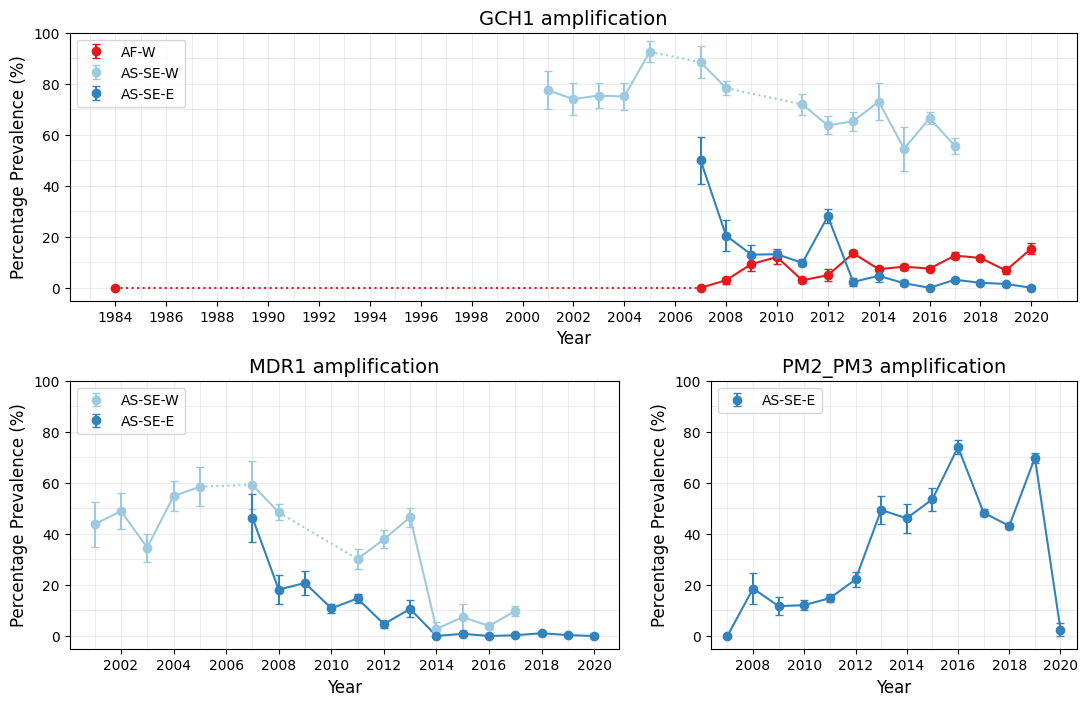

In [ ]:
# Create the figure layout
fig = plt.figure(figsize = (13, 8))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[3, 2])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Set variables used when looping over populations
plotting_data = [
    {"pop_of_interest": "AF-W", "pop_colour": "#e31a1c", "column_of_interest": "GCH1_final_amplification_call", "subplot_axis": ax1, "title": "GCH1 amplification"},
    {"pop_of_interest": "AS-SE-W", "pop_colour": "#9ecae1", "column_of_interest": "GCH1_final_amplification_call", "subplot_axis": ax1, "title": "GCH1 amplification"},
    {"pop_of_interest": "AS-SE-E", "pop_colour": "#3182bd", "column_of_interest": "GCH1_final_amplification_call", "subplot_axis": ax1, "title": "GCH1 amplification"},
    {"pop_of_interest": "AS-SE-W", "pop_colour": "#9ecae1", "column_of_interest": "MDR1_final_amplification_call", "subplot_axis": ax2, "title": "MDR1 amplification"},
    {"pop_of_interest": "AS-SE-E", "pop_colour": "#3182bd", "column_of_interest": "MDR1_final_amplification_call", "subplot_axis": ax2, "title": "MDR1 amplification"},
    {"pop_of_interest": "AS-SE-E", "pop_colour": "#3182bd", "column_of_interest": "PM2_PM3_final_amplification_call", "subplot_axis": ax3, "title": "PM2_PM3 amplification"},
]

# Loop starts
for item in plotting_data:
    pop_of_interest    = item["pop_of_interest"]
    pop_colour         = item["pop_colour"]
    column_of_interest = item["column_of_interest"]
    subplot_axis       = item["subplot_axis"]
    title              = item["title"]

    # subset call-region and population specific dataset
    subset_df = merge_df.loc[
        (merge_df[column_of_interest] != -1) &
        (merge_df.Population == pop_of_interest)
    ]
    # calculate prevalence after grouping samples by year
    longitudinal_data = subset_df.groupby("Year")[column_of_interest].apply(lambda x: pd.Series({
        "ratio": sum(x == 1) / sum(x != -1),
        "cnv_gt_1": sum(x == 1),
        "cnv_gt_0_1": sum(x != -1)
    })).unstack().reset_index().astype({"Year": int, "cnv_gt_1": int, "cnv_gt_0_1": int})

    # use only data points with sample size is >25
    longitudinal_data = longitudinal_data.loc[longitudinal_data.cnv_gt_0_1 >= 25]

    if len(longitudinal_data) < 5:
        continue

    if longitudinal_data.ratio.sum() < 0.1:
        continue

    # calculate standard error using our function
    longitudinal_data["standard_error"] = longitudinal_data.apply(calculate_standard_error, axis=1)

    # plot data points and error bars
    subplot_axis.errorbar(
        longitudinal_data.Year, longitudinal_data.ratio * 100,
        yerr=longitudinal_data.standard_error * 100,
        fmt="o", capsize=3, color=pop_colour,
        label=pop_of_interest
    )

  # CONNECTION LINES
    # Sort data for consistent line drawing
    longitudinal_data = longitudinal_data.sort_values("Year")

    # Iterate over consecutive points to apply different line styles
    gap_threshold  = 1
    for i in range(len(longitudinal_data) - 1):
        x1, x2 = longitudinal_data.iloc[i]["Year"], longitudinal_data.iloc[i + 1]["Year"]
        y1, y2 = longitudinal_data.iloc[i]["ratio"] * 100, longitudinal_data.iloc[i + 1]["ratio"] * 100

        linestyle = "-" if (x2 - x1) <= gap_threshold else ":"  # Solid if close, dotted if far
        subplot_axis.plot([x1, x2], [y1, y2], color=pop_colour, linestyle=linestyle)



  # SUBPLOT LAYOUT
    # Labels
    subplot_axis.set_title(title, y=1, fontsize = 14)
    subplot_axis.set_xlabel("Year", fontsize = 12)
    subplot_axis.set_ylabel("Percentage Prevalence (%)", fontsize = 12)
    # y-axis limits
    subplot_axis.set_ylim(-5, 100)
    x_min, x_max = subplot_axis.get_xlim()

    # display every two year
    x_tick_interval = 2

    # position of ticks
    xticks = np.arange(
        x_min // x_tick_interval * x_tick_interval + x_tick_interval,
        x_max // x_tick_interval * x_tick_interval + x_tick_interval,
        x_tick_interval
    )
    # plot tick labels
    subplot_axis.set_xticks(xticks)
    subplot_axis.set_xticklabels([str(int(year)) for year in xticks])

for subplot_axis in [ax1, ax2, ax3]:
  # plot y-axis ticks
    for y in np.arange(0, 100, 10).astype(int):
        subplot_axis.axhline(y=y, linewidth=0.5, alpha=0.1, color="black", zorder=-1)
  # plot x-axis ticks
    x_min, x_max = subplot_axis.get_xlim()
    for x in np.arange(x_min + x_tick_interval - 1, x_max).astype(int):
        subplot_axis.axvline(x=x, linewidth=0.5, alpha=0.1, color="black", zorder=-1)
  # adjust legend position
    subplot_axis.legend(loc="upper left")

plt.subplots_adjust(hspace=0.3)
plt.show()

**Figure Legend**. Time-series plots of CNV prevalence in selected populations. Points represent years for which more than 25 calls were available for a given country, while error bars show the standard error for each resistance estimate for any given year. Solid lines connect consecutive time points, while dotted lines indicate gaps greater than one year between adjacent time points. Percentage prevalences were computed using samples with non-missing CNV calls for the gene.

### Save the figure

In [ ]:
fig.savefig(f"/content/drive/My Drive/pf8_temporal_cnv.png", dpi=1200)